# Loan Approval Model

**Purpose:** The purpose of this notebook is to work with machine learning techniques to make the best model for approving or denying loan applications.

**Result:** Able to produce a model with approximately 80% accuracy.

## Table of Contents

* **[Analyzing the Data](#Analyzing-the-Data)**
* **[Cleaning the Data](#Cleaning-the-Data)**
* **[Modeling the Data](#Modeling-the-Data)**

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/loan-prediction-problem-dataset/test_Y3wMUE5_7gLdaTN.csv
/kaggle/input/loan-prediction-problem-dataset/train_u6lujuX_CVtuZ9i.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

test = pd.read_csv('/kaggle/input/loan-prediction-problem-dataset/test_Y3wMUE5_7gLdaTN.csv')
train = pd.read_csv('/kaggle/input/loan-prediction-problem-dataset/train_u6lujuX_CVtuZ9i.csv')
train_original = train.copy()
test_original = test.copy()

## Analyzing the Data

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [4]:
#plt.hist(train['ApplicantIncome']) #Will need to do a log transformation on this column
#plt.hist(train['CoapplicantIncome']) #Will need to do a log transformation on this column
#plt.hist(train['LoanAmount']) #Will need to do a log transformation on this column
#plt.hist(train['Loan_Amount_Term'])
#plt.hist(train['Credit_History'])

Will need to apply log transformations on the test columns ApplicantIncome, CoapplicantIncome and LoanAmount.

In [5]:
train.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


We have some missing data in LoanAmount, Loan_Amount_Term and Credit_History that will have to get cleaned up. 

<AxesSubplot:title={'center':'Genders'}>

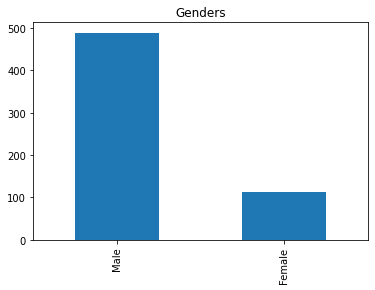

In [6]:
plt.title('Genders')
train['Gender'].value_counts().plot.bar()

Working with what looks like about three times as many Males than Females in the train dataset.

<AxesSubplot:title={'center':'Marital Status'}>

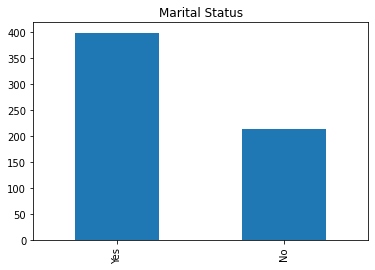

In [7]:
plt.title('Marital Status')
train['Married'].value_counts().plot.bar()

Married is essentially a boolean column split up into yes and no answers. Looks like more of the train dataset includes people who are married.

<AxesSubplot:title={'center':'Dependents'}>

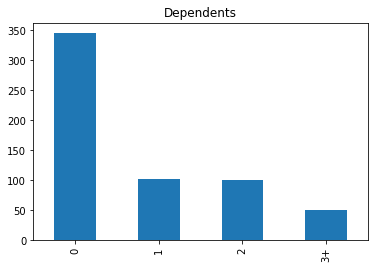

In [8]:
plt.title('Dependents')
train['Dependents'].value_counts().plot.bar()

The dependents column looks to be a column illustrating the amount of people that an independent claims. Most of the independents applying for loans look to have 0 dependents.

<AxesSubplot:title={'center':'Education'}>

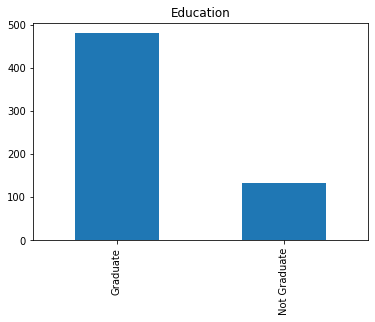

In [9]:
plt.title('Education')
train['Education'].value_counts().plot.bar()

For the education column what we see is a little vague. No data description is given of this column. We see that there are more graduates than not, but we are not sure if this means people that graduate high school or university. The assumption would be that a graduate would mean from university, but we cannot be certain.

<AxesSubplot:title={'center':'Self-Employed'}>

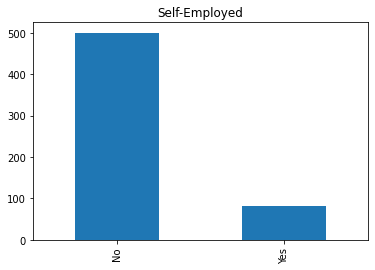

In [10]:
plt.title('Self-Employed')
train['Self_Employed'].value_counts().plot.bar()

This column is straight forward and it looks like most loan applicants are not self-employed.

<AxesSubplot:title={'center':'Property Area'}>

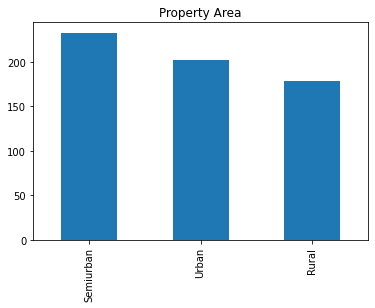

In [11]:
plt.title('Property Area')
train['Property_Area'].value_counts().plot.bar()

We seem to have a pretty equal distribution of property area, semiurban being the most popular area.

Y    422
N    192
Name: Loan_Status, dtype: int64

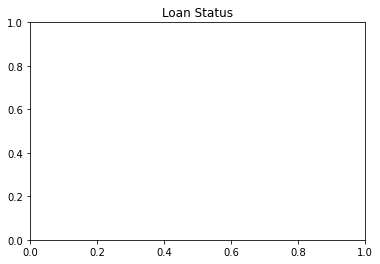

In [12]:
plt.title('Loan Status')
train['Loan_Status'].value_counts()

Our last and most important column for our machine learning is the loan status column. This is the column that we are looking too predict. From here it looks like a good majority of applicants in the train dataset got there loan application approved.

From what is seen above it might be helpful to convert some of these columns to boolean. However we will do some categorical encoding, so it might be better to just leave as is.

## Cleaning the Data

For cleaning the data there are a couple of tasks that will need to be done in order to make sure that the model is running the best it can.
* Clean up the missing values
* Check for any duplicates
* Make a separate train dataset where the columns that needed a logistic regression earlier are modified.

### Cleaning Missing Values

So the process does not have to be done twice for train and test, the datasets will be merged while it is cleaned and then split back up after the data is put together like wanted.

In [13]:
ntrain = train.shape[0]
ntest = test.shape[0]
y = train.Loan_Status.values
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['Loan_Status'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))


#Credit to: https://stackoverflow.com/questions/18172851/deleting-dataframe-row-in-pandas-based-on-column-value for helping me understand the correct way to drop my columns

all_data size is : (981, 12)


Now we have a dataset with the combination of rows for train and test and the loan_status column dropped.

In [14]:
#Checking percentage of data that is na
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(7)

,Missing Ratio
Credit_History,8.053007
Self_Employed,5.606524
LoanAmount,2.752294
Dependents,2.548420
Gender,2.446483
Loan_Amount_Term,2.038736
Married,0.305810


Because we have such a low percentage of missing values in each row it can be seen that none of these rows will need to be dropped, just cleaned up.

In [15]:
all_data.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban


In [16]:
all_data.LoanAmount.describe()

count    954.000000
mean     142.511530
std       77.421743
min        9.000000
25%      100.000000
50%      126.000000
75%      162.000000
max      700.000000
Name: LoanAmount, dtype: float64

Above I just wanted to quickly confirm that zero was not being counted as an NaN value or that No's were considered NaN's. As seen with the describe for Loan Amount column the lowest amount that there is, is nine which means that zeros are not apart of our range of values.

#### Cleaning Numeric Variables

Now that we are setup to start cleaning the missing data we will split up the data into numeric and categorical variables.

In [17]:
Numeric_Columns = all_data.select_dtypes(include=np.number) #Creating dataset for just the numeric columns
Numeric_Columns.head()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
0,5849,0.0,NaN,360.0,1.0
1,4583,1508.0,128.0,360.0,1.0
2,3000,0.0,66.0,360.0,1.0
3,2583,2358.0,120.0,360.0,1.0
4,6000,0.0,141.0,360.0,1.0


For this part of the process I am going to use simple imputer to quickly and effectively deal with my numeric missing data

In [18]:
from sklearn.impute import SimpleImputer

my_imputer = SimpleImputer()
imputed_num = pd.DataFrame(my_imputer.fit_transform(Numeric_Columns)) #Using simple imputer to fill in missing values

imputed_num.columns = Numeric_Columns.columns #Making column headings the same for imputed_num as Numeric_Columns
identification = all_data['Loan_ID'] #Making a column for Loan_ID to merge numerical and categorical data
imputed_num = imputed_num.join(identification)
imputed_num.head()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_ID
0,5849.0,0.0,142.51153,360.0,1.0,LP001002
1,4583.0,1508.0,128.00000,360.0,1.0,LP001003
2,3000.0,0.0,66.00000,360.0,1.0,LP001005
3,2583.0,2358.0,120.00000,360.0,1.0,LP001006
4,6000.0,0.0,141.00000,360.0,1.0,LP001008


#### Cleaning Categorical Variables

For cleaning the categorical variables I am going to use get_dummies to effectively clean. This will also prove effective for my model.

In [19]:
Categorical_Columns = all_data.select_dtypes(exclude=np.number)
Categorical_Columns.drop(['Loan_ID'], axis=1, inplace=True)
Categorical_Columns.head()

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4315: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Gender,Married,Dependents,Education,Self_Employed,Property_Area
0,Male,No,0,Graduate,No,Urban
1,Male,Yes,1,Graduate,No,Rural
2,Male,Yes,0,Graduate,Yes,Urban
3,Male,Yes,0,Not Graduate,No,Urban
4,Male,No,0,Graduate,No,Urban


In [20]:
imputed_categorical = pd.get_dummies(data=Categorical_Columns) #Using get_dummies to clean up categorical data
imputed_categorical.head()

,Gender_Female,Gender_Male,Married_No,Married_Yes,Dependents_0,Dependents_1,Dependents_2,Dependents_3+,Education_Graduate,Education_Not Graduate,Self_Employed_No,Self_Employed_Yes,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban
0,0,1,1,0,1,0,0,0,1,0,1,0,0,0,1
1,0,1,0,1,0,1,0,0,1,0,1,0,1,0,0
2,0,1,0,1,1,0,0,0,1,0,0,1,0,0,1
3,0,1,0,1,1,0,0,0,0,1,1,0,0,0,1
4,0,1,1,0,1,0,0,0,1,0,1,0,0,0,1


In [21]:
imputed_categorical = imputed_categorical.join(identification)
imputed_categorical.head()

,Gender_Female,Gender_Male,Married_No,Married_Yes,Dependents_0,Dependents_1,Dependents_2,Dependents_3+,Education_Graduate,Education_Not Graduate,Self_Employed_No,Self_Employed_Yes,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban,Loan_ID
0,0,1,1,0,1,0,0,0,1,0,1,0,0,0,1,LP001002
1,0,1,0,1,0,1,0,0,1,0,1,0,1,0,0,LP001003
2,0,1,0,1,1,0,0,0,1,0,0,1,0,0,1,LP001005
3,0,1,0,1,1,0,0,0,0,1,1,0,0,0,1,LP001006
4,0,1,1,0,1,0,0,0,1,0,1,0,0,0,1,LP001008


#### Merging Numerical Dataset and Categorical Dataset Together

In [22]:
merged_data = imputed_num.merge(imputed_categorical, on='Loan_ID') #Using similar id columns to merge data
merged_data.drop(['Loan_ID'], axis=1, inplace=True) #Need to drop Loan_ID now that we have successfully merged our data together
merged_data.head()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Gender_Female,Gender_Male,Married_No,Married_Yes,Dependents_0,Dependents_1,Dependents_2,Dependents_3+,Education_Graduate,Education_Not Graduate,Self_Employed_No,Self_Employed_Yes,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban
0,5849.0,0.0,142.51153,360.0,1.0,0,1,1,0,1,0,0,0,1,0,1,0,0,0,1
1,4583.0,1508.0,128.00000,360.0,1.0,0,1,0,1,0,1,0,0,1,0,1,0,1,0,0
2,3000.0,0.0,66.00000,360.0,1.0,0,1,0,1,1,0,0,0,1,0,0,1,0,0,1
3,2583.0,2358.0,120.00000,360.0,1.0,0,1,0,1,1,0,0,0,0,1,1,0,0,0,1
4,6000.0,0.0,141.00000,360.0,1.0,0,1,1,0,1,0,0,0,1,0,1,0,0,0,1


In [23]:
all_data_nan = (merged_data.isnull().sum() / len(merged_data)) * 100
all_data_nan = all_data_nan.drop(all_data_nan[all_data_nan == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_nan})
missing_data.head(10)

,Missing Ratio


As can be seen above we no longer have any missing values. We are going to go ahead and split our data back up into our train and test datasets and then do the same process and make a separate dataset that contains our logarithmic columns.

In [24]:
X_tra = merged_data[:ntrain]
X_test = merged_data[ntrain:]
X_tra.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 614 entries, 0 to 613
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ApplicantIncome          614 non-null    float64
 1   CoapplicantIncome        614 non-null    float64
 2   LoanAmount               614 non-null    float64
 3   Loan_Amount_Term         614 non-null    float64
 4   Credit_History           614 non-null    float64
 5   Gender_Female            614 non-null    uint8  
 6   Gender_Male              614 non-null    uint8  
 7   Married_No               614 non-null    uint8  
 8   Married_Yes              614 non-null    uint8  
 9   Dependents_0             614 non-null    uint8  
 10  Dependents_1             614 non-null    uint8  
 11  Dependents_2             614 non-null    uint8  
 12  Dependents_3+            614 non-null    uint8  
 13  Education_Graduate       614 non-null    uint8  
 14  Education_Not Graduate   6

## Logarithmic Cleaning

In [25]:
log_train = train_original
log_test = test_original
log_train.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


The columns that we are replacing with logarithm values are:
* ApplicantIncome
* CoapplicantIncome
* LoanAmount

First we will start again by merging the log_train and log_test and then perform the transformations.

In [26]:
log_train.drop(log_train.loc[log_train['ApplicantIncome']==0].index, inplace=True)
log_train.drop(log_train.loc[log_train['CoapplicantIncome']==0].index, inplace=True)
log_train.drop(log_train.loc[log_train['LoanAmount']==0].index, inplace=True)

log_test.drop(log_test.loc[log_test['ApplicantIncome']==0].index, inplace=True)
log_test.drop(log_test.loc[log_test['CoapplicantIncome']==0].index, inplace=True)
log_test.drop(log_test.loc[log_test['LoanAmount']==0].index, inplace=True)

In [27]:
nlogtrain = log_train.shape[0]
nlogtest = log_test.shape[0]
y_log = log_train.Loan_Status.values
all_data_log = pd.concat((log_train, log_test)).reset_index(drop=True)
all_data_log.drop(['Loan_Status'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data_log.shape))

all_data size is : (550, 12)


The log transformation will not be insightful if we have values equal to zero, so if that is the case we will need to drop them.

In [28]:
#Perform log transformations
all_data_log['ApplicantIncome_log'] = np.log(all_data_log['ApplicantIncome'])
all_data_log['CoapplicantIncome_log'] = np.log(all_data_log['CoapplicantIncome'])
all_data_log['LoanAmount_log'] = np.log(all_data_log['LoanAmount'])
all_data_log.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,ApplicantIncome_log,CoapplicantIncome_log,LoanAmount_log
0,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,8.430109,7.318540,4.852030
1,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,7.856707,7.765569,4.787492
2,LP001011,Male,Yes,2,Graduate,Yes,5417,4196.0,267.0,360.0,1.0,Urban,8.597297,8.341887,5.587249
3,LP001013,Male,Yes,0,Not Graduate,No,2333,1516.0,95.0,360.0,1.0,Urban,7.754910,7.323831,4.553877
4,LP001014,Male,Yes,3+,Graduate,No,3036,2504.0,158.0,360.0,0.0,Semiurban,8.018296,7.825645,5.062595


In [29]:
all_data_log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550 entries, 0 to 549
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Loan_ID                550 non-null    object 
 1   Gender                 536 non-null    object 
 2   Married                549 non-null    object 
 3   Dependents             538 non-null    object 
 4   Education              550 non-null    object 
 5   Self_Employed          517 non-null    object 
 6   ApplicantIncome        550 non-null    int64  
 7   CoapplicantIncome      550 non-null    float64
 8   LoanAmount             538 non-null    float64
 9   Loan_Amount_Term       535 non-null    float64
 10  Credit_History         499 non-null    float64
 11  Property_Area          550 non-null    object 
 12  ApplicantIncome_log    550 non-null    float64
 13  CoapplicantIncome_log  550 non-null    float64
 14  LoanAmount_log         538 non-null    float64
dtypes: flo

Now we have a lot less rows to work with, but we are able to get log transformations that will be useful. Let's verify that we have a approximately normal distribution now by taking a look at the plots.

(array([  2.,   1.,   4.,   8., 105., 283., 110.,  29.,   7.,   1.]),
 array([ 5.01063529,  5.56707967,  6.12352405,  6.67996843,  7.2364128 ,
         7.79285718,  8.34930156,  8.90574594,  9.46219031, 10.01863469,
        10.57507907]),
 <BarContainer object of 10 artists>)

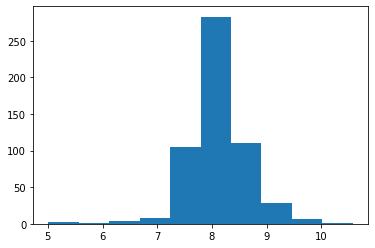

In [30]:
plt.hist(all_data_log['ApplicantIncome_log']) 

(array([  1.,   0.,   0.,   8.,  25., 153., 276.,  76.,   7.,   4.]),
 array([ 2.78006079,  3.56580118,  4.35154158,  5.13728197,  5.92302236,
         6.70876276,  7.49450315,  8.28024355,  9.06598394,  9.85172433,
        10.63746473]),
 <BarContainer object of 10 artists>)

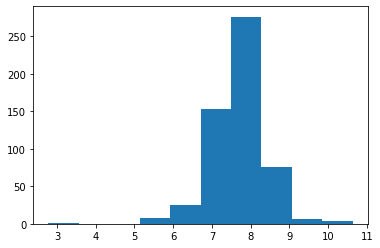

In [31]:
plt.hist(all_data_log['CoapplicantIncome_log']) 

(array([  1.,   4.,   5.,  14.,  53., 234., 166.,  39.,  16.,   6.]),
 array([2.83321334, 3.18445565, 3.53569795, 3.88694025, 4.23818255,
        4.58942485, 4.94066715, 5.29190946, 5.64315176, 5.99439406,
        6.34563636]),
 <BarContainer object of 10 artists>)

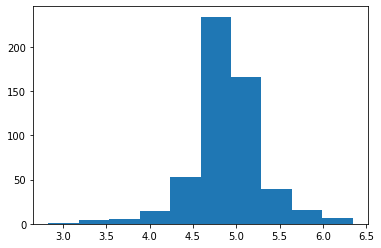

In [32]:
plt.hist(all_data_log['LoanAmount_log'])

We can verify that these are now approximately normally distributed. From here we will go ahead and drop the original columns associated with the log transformations and then follow the same steps as with the all_data dataset with how we will clean.

In [33]:
all_data_log.drop(['ApplicantIncome'], axis=1, inplace=True)
all_data_log.drop(['CoapplicantIncome'], axis=1, inplace=True)
all_data_log.drop(['LoanAmount'], axis=1, inplace=True)

In [34]:
all_data_log.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,Loan_Amount_Term,Credit_History,Property_Area,ApplicantIncome_log,CoapplicantIncome_log,LoanAmount_log
0,LP001003,Male,Yes,1,Graduate,No,360.0,1.0,Rural,8.430109,7.318540,4.852030
1,LP001006,Male,Yes,0,Not Graduate,No,360.0,1.0,Urban,7.856707,7.765569,4.787492
2,LP001011,Male,Yes,2,Graduate,Yes,360.0,1.0,Urban,8.597297,8.341887,5.587249
3,LP001013,Male,Yes,0,Not Graduate,No,360.0,1.0,Urban,7.754910,7.323831,4.553877
4,LP001014,Male,Yes,3+,Graduate,No,360.0,0.0,Semiurban,8.018296,7.825645,5.062595


In [35]:
Numeric_Columns_log = all_data_log.select_dtypes(include=np.number) #Creating dataset for just the numeric columns
Numeric_Columns_log.head()

,Loan_Amount_Term,Credit_History,ApplicantIncome_log,CoapplicantIncome_log,LoanAmount_log
0,360.0,1.0,8.430109,7.318540,4.852030
1,360.0,1.0,7.856707,7.765569,4.787492
2,360.0,1.0,8.597297,8.341887,5.587249
3,360.0,1.0,7.754910,7.323831,4.553877
4,360.0,0.0,8.018296,7.825645,5.062595


In [36]:
imputed_num_log = pd.DataFrame(my_imputer.fit_transform(Numeric_Columns_log)) #Using simple imputer to fill in missing values

imputed_num_log.columns = Numeric_Columns_log.columns #Making column headings the same for imputed_num as Numeric_Columns
identification_log = all_data_log['Loan_ID'] #Making a column for Loan_ID to merge numerical and categorical data
imputed_num_log = imputed_num_log.join(identification_log)
imputed_num_log.head()

,Loan_Amount_Term,Credit_History,ApplicantIncome_log,CoapplicantIncome_log,LoanAmount_log,Loan_ID
0,360.0,1.0,8.430109,7.318540,4.852030,LP001003
1,360.0,1.0,7.856707,7.765569,4.787492,LP001006
2,360.0,1.0,8.597297,8.341887,5.587249,LP001011
3,360.0,1.0,7.754910,7.323831,4.553877,LP001013
4,360.0,0.0,8.018296,7.825645,5.062595,LP001014


In [37]:
Categorical_Columns_log = all_data_log.select_dtypes(exclude=np.number)
Categorical_Columns_log.drop(['Loan_ID'], axis=1, inplace=True)
Categorical_Columns_log.head()

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4315: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Gender,Married,Dependents,Education,Self_Employed,Property_Area
0,Male,Yes,1,Graduate,No,Rural
1,Male,Yes,0,Not Graduate,No,Urban
2,Male,Yes,2,Graduate,Yes,Urban
3,Male,Yes,0,Not Graduate,No,Urban
4,Male,Yes,3+,Graduate,No,Semiurban


In [38]:
imputed_categorical_log = pd.get_dummies(data=Categorical_Columns_log) #Using get_dummies to clean up categorical data
imputed_categorical_log.head()

,Gender_Female,Gender_Male,Married_No,Married_Yes,Dependents_0,Dependents_1,Dependents_2,Dependents_3+,Education_Graduate,Education_Not Graduate,Self_Employed_No,Self_Employed_Yes,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban
0,0,1,0,1,0,1,0,0,1,0,1,0,1,0,0
1,0,1,0,1,1,0,0,0,0,1,1,0,0,0,1
2,0,1,0,1,0,0,1,0,1,0,0,1,0,0,1
3,0,1,0,1,1,0,0,0,0,1,1,0,0,0,1
4,0,1,0,1,0,0,0,1,1,0,1,0,0,1,0


In [39]:
imputed_categorical_log = imputed_categorical_log.join(identification_log)
imputed_categorical_log.head()

,Gender_Female,Gender_Male,Married_No,Married_Yes,Dependents_0,Dependents_1,Dependents_2,Dependents_3+,Education_Graduate,Education_Not Graduate,Self_Employed_No,Self_Employed_Yes,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban,Loan_ID
0,0,1,0,1,0,1,0,0,1,0,1,0,1,0,0,LP001003
1,0,1,0,1,1,0,0,0,0,1,1,0,0,0,1,LP001006
2,0,1,0,1,0,0,1,0,1,0,0,1,0,0,1,LP001011
3,0,1,0,1,1,0,0,0,0,1,1,0,0,0,1,LP001013
4,0,1,0,1,0,0,0,1,1,0,1,0,0,1,0,LP001014


In [40]:
merged_data_log = imputed_num_log.merge(imputed_categorical_log, on='Loan_ID') #Using similar id columns to merge data
merged_data_log.drop(['Loan_ID'], axis=1, inplace=True) #Need to drop Loan_ID now that we have successfully merged our data together
merged_data_log.head()

,Loan_Amount_Term,Credit_History,ApplicantIncome_log,CoapplicantIncome_log,LoanAmount_log,Gender_Female,Gender_Male,Married_No,Married_Yes,Dependents_0,Dependents_1,Dependents_2,Dependents_3+,Education_Graduate,Education_Not Graduate,Self_Employed_No,Self_Employed_Yes,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban
0,360.0,1.0,8.430109,7.318540,4.852030,0,1,0,1,0,1,0,0,1,0,1,0,1,0,0
1,360.0,1.0,7.856707,7.765569,4.787492,0,1,0,1,1,0,0,0,0,1,1,0,0,0,1
2,360.0,1.0,8.597297,8.341887,5.587249,0,1,0,1,0,0,1,0,1,0,0,1,0,0,1
3,360.0,1.0,7.754910,7.323831,4.553877,0,1,0,1,1,0,0,0,0,1,1,0,0,0,1
4,360.0,0.0,8.018296,7.825645,5.062595,0,1,0,1,0,0,0,1,1,0,1,0,0,1,0


In [41]:
all_data_log_nan = (merged_data_log.isnull().sum() / len(merged_data_log)) * 100
all_data_log_nan = all_data_log_nan.drop(all_data_log_nan[all_data_log_nan == 0].index).sort_values(ascending=False)[:30]
missing_data_log = pd.DataFrame({'Missing Ratio' :all_data_log_nan})
missing_data_log.head(10)

,Missing Ratio


In [42]:
X_tra_log = merged_data[:nlogtrain]
X_test_log = merged_data[nlogtrain:]
X_tra_log.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 341 entries, 0 to 340
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ApplicantIncome          341 non-null    float64
 1   CoapplicantIncome        341 non-null    float64
 2   LoanAmount               341 non-null    float64
 3   Loan_Amount_Term         341 non-null    float64
 4   Credit_History           341 non-null    float64
 5   Gender_Female            341 non-null    uint8  
 6   Gender_Male              341 non-null    uint8  
 7   Married_No               341 non-null    uint8  
 8   Married_Yes              341 non-null    uint8  
 9   Dependents_0             341 non-null    uint8  
 10  Dependents_1             341 non-null    uint8  
 11  Dependents_2             341 non-null    uint8  
 12  Dependents_3+            341 non-null    uint8  
 13  Education_Graduate       341 non-null    uint8  
 14  Education_Not Graduate   3

## Modeling the Data

Now we are into the fun part working with building the best model we can for this data. A couple methods will be done. We are going to be using train_test_split and trying a couple different models like LogisticRegression, DecisionTreeClassifier, RandomForest and XGBoost. We will start with our original dataset and then like with the cleaning do the same methods with our log transformation dataset to see if that improved our model at all.

### Base Modeling with train_test_split

In [43]:
from sklearn.model_selection import train_test_split
X_train, X_cv, y_train, y_cv = train_test_split(X_tra, y, test_size =.3)

In [44]:
from sklearn.linear_model import LogisticRegression

log_model = LogisticRegression()
log_model.fit(X_train, y_train)
LogisticRegression()

LogisticRegression()

In [45]:
from sklearn.metrics import accuracy_score
log_pred_cv = log_model.predict(X_cv)
accuracy_score(y_cv, log_pred_cv)

0.7675675675675676

It looks like our first model is about 80-85% accurate which is not bad at all, but we will work to do see if a better model can be achieved starting with a DecisionTreeClassifier.

In [46]:
from sklearn import tree

tree_model = tree.DecisionTreeClassifier()
tree_model.fit(X_train, y_train)
tree.DecisionTreeClassifier()

DecisionTreeClassifier()

In [47]:
tree_pred_cv = tree_model.predict(X_cv)
accuracy_score(y_cv, tree_pred_cv)

0.7513513513513513

Not as accurate as the logistic regression model, but we will see how a random forest classifier handles the dataset.

In [48]:
from sklearn.ensemble import RandomForestClassifier

forest_model = RandomForestClassifier()
forest_model.fit(X_train, y_train)
RandomForestClassifier()

RandomForestClassifier()

In [49]:
forest_pred_cv = forest_model.predict(X_cv)
accuracy_score(y_cv, forest_pred_cv)

0.7675675675675676

This model did better than the decision tree, but still not as good as the logistic regression. We will try one more method which is XGBoost.

In [50]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(n_estimators=50, max_depth=4)
xgb_model.fit(X_train, y_train)
XGBClassifier()

[00:16:06] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None)

In [51]:
xgb_pred_cv = xgb_model.predict(X_cv)
accuracy_score(y_cv, xgb_pred_cv)

/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


0.7513513513513513

Our xgb did not do as well as the logistic regression model, so we will go ahead and just try to beef up the logistic regression model the best it can be. This starts with seeing if our log transformations helped the model.

### Log Dataset Modeling

In [52]:
X_train_log, X_cv_log, y_train_log, y_cv_log = train_test_split(X_tra_log, y_log, test_size =.3)

In [53]:
log_model.fit(X_train_log, y_train_log)
LogisticRegression()

LogisticRegression()

In [54]:
log_pred_cv_log = log_model.predict(X_cv_log)
accuracy_score(y_cv_log, log_pred_cv_log)

0.7184466019417476

As it appears the making of new columns for log transformations was not very influential for finding a good model.

#### Final Model

It seems like our basic logistic regression model actually appeared to do the best for this dataset. Before calling it quits a few things will be checked out to see if any slight improvements can be made to our Logistic Regression model.

In [55]:
#Credit for ideas on improvement: https://stackoverflow.com/questions/38077190/how-to-increase-the-model-accuracy-of-logistic-regression-in-scikit-python
#Credit for ideas on improvement: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

#log_model = LogisticRegression()
#log_model.fit(X_train, y_train)
#LogisticRegression()

#log_pred_cv = log_model.predict(X_cv)
#accuracy_score(y_cv, log_pred_cv)

In [56]:
log_model1 = LogisticRegression(random_state=42)
log_model1.fit(X_train, y_train)

log_pred_cv1 = log_model1.predict(X_cv)
accuracy_score(y_cv, log_pred_cv1)
#We get about the same results

0.7675675675675676

In [57]:
log_model2 = LogisticRegression(random_state=42, solver='lbfgs')
log_model2.fit(X_train, y_train)

log_pred_cv2 = log_model2.predict(X_cv)
accuracy_score(y_cv, log_pred_cv2)

0.7675675675675676

In [58]:
#Our final model will be our log_model2 and we want to now use it to predict based on the information in our test dataset
final_model = log_model2
pred_test = final_model.predict(X_test)

In [59]:
#Make new dataframe for our identification and loan_status predictions
submission = pd.DataFrame()

#Putting data into submission dataframe
submission['Loan_Status'] = pred_test
submission['Loan_ID'] = test_original['Loan_ID']

#Makes more sense to put in terms of 'Y' and 'N' instead of 1 and 0 when talking about a loan being approved
submission['Loan_Status'].replace(0, 'N', inplace=True)
submission['Loan_Status'].replace(1, 'Y', inplace=True)

submission.Loan_Status.value_counts()

Y    307
N     60
Name: Loan_Status, dtype: int64

From this we are predicting that the test dataset will have 305 accepted loans and 62 denied loans. Thinking back to the amount of loans that were approved and denied in the train dataset there were about 68% of applications that were accepted. With our model there are about 83% of applications that are accepted. This could be in part to either the fact that we are 80% accurate or the fact that there are simply more applicants in the test dataset that would qualify for a loan than in the train dataset.